In [1]:
import numpy as np
from numpy._typing import NDArray
import pandas as pd

In [2]:
from utils import preprocess_data_sample, get_metadata

In [3]:
metadata: pd.DataFrame = get_metadata()
metadata

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


### Bring a data sample

In [4]:
df, target = preprocess_data_sample(1, metadata)

In [5]:
df

,time,v
time_abs(%Y-%m-%dT%H:%M:%S.%f),,
1970-03-25 00:00:00.440000,0.000000,-5.481780e-15
1970-03-25 00:00:00.590943,0.150943,-6.878653e-15
1970-03-25 00:00:00.741887,0.301887,-7.486137e-15
1970-03-25 00:00:00.892830,0.452830,-7.191481e-15
1970-03-25 00:00:01.043774,0.603774,-6.287278e-15
...,...,...
1970-03-26 00:00:01.345660,86400.905660,8.188906e-16
1970-03-26 00:00:01.496604,86401.056604,-6.852630e-17
1970-03-26 00:00:01.647547,86401.207547,-8.490759e-16


In [6]:
time: NDArray = df['time'].resample('min').mean().values
v: NDArray = df['v'].resample('min').max().values

### Utils

In [7]:
from utils import dx_dt, dx2_dt2, create_graph, butterworth_filter, spectogram_sfft, gaussian, total_variation_forward, total_variation_backward

def main(sample: str, spec_div: int, nperseg: int) -> None:
    time: NDArray = df['time'].resample(sample).mean().values
    v_max: NDArray = df['v'].resample(sample).max().values
    v_mean: NDArray = df['v'].resample(sample).mean().values
    
    create_graph(
        lambda ax, idx: dx_dt(ax, idx, time, v_max, target),
        lambda ax, idx: dx2_dt2(ax, idx, time, v_max, target),
        lambda ax, idx: butterworth_filter(ax, idx, time, v_max, target),
        lambda ax, idx: spectogram_sfft(ax, idx, v_mean, 1 / spec_div, nperseg, target),
        lambda ax, idx: gaussian(ax, idx, time, v_mean, target),
        lambda ax, idx: total_variation_forward(ax, idx, time, v_mean, target),
        lambda ax, idx: total_variation_backward(ax, idx, time, v_mean, target),
    )

## High resolution analysis

It's important to note that our main goal is the classification task, this implies that any data transformation to address that point would be useful towards the Machine Learning step.

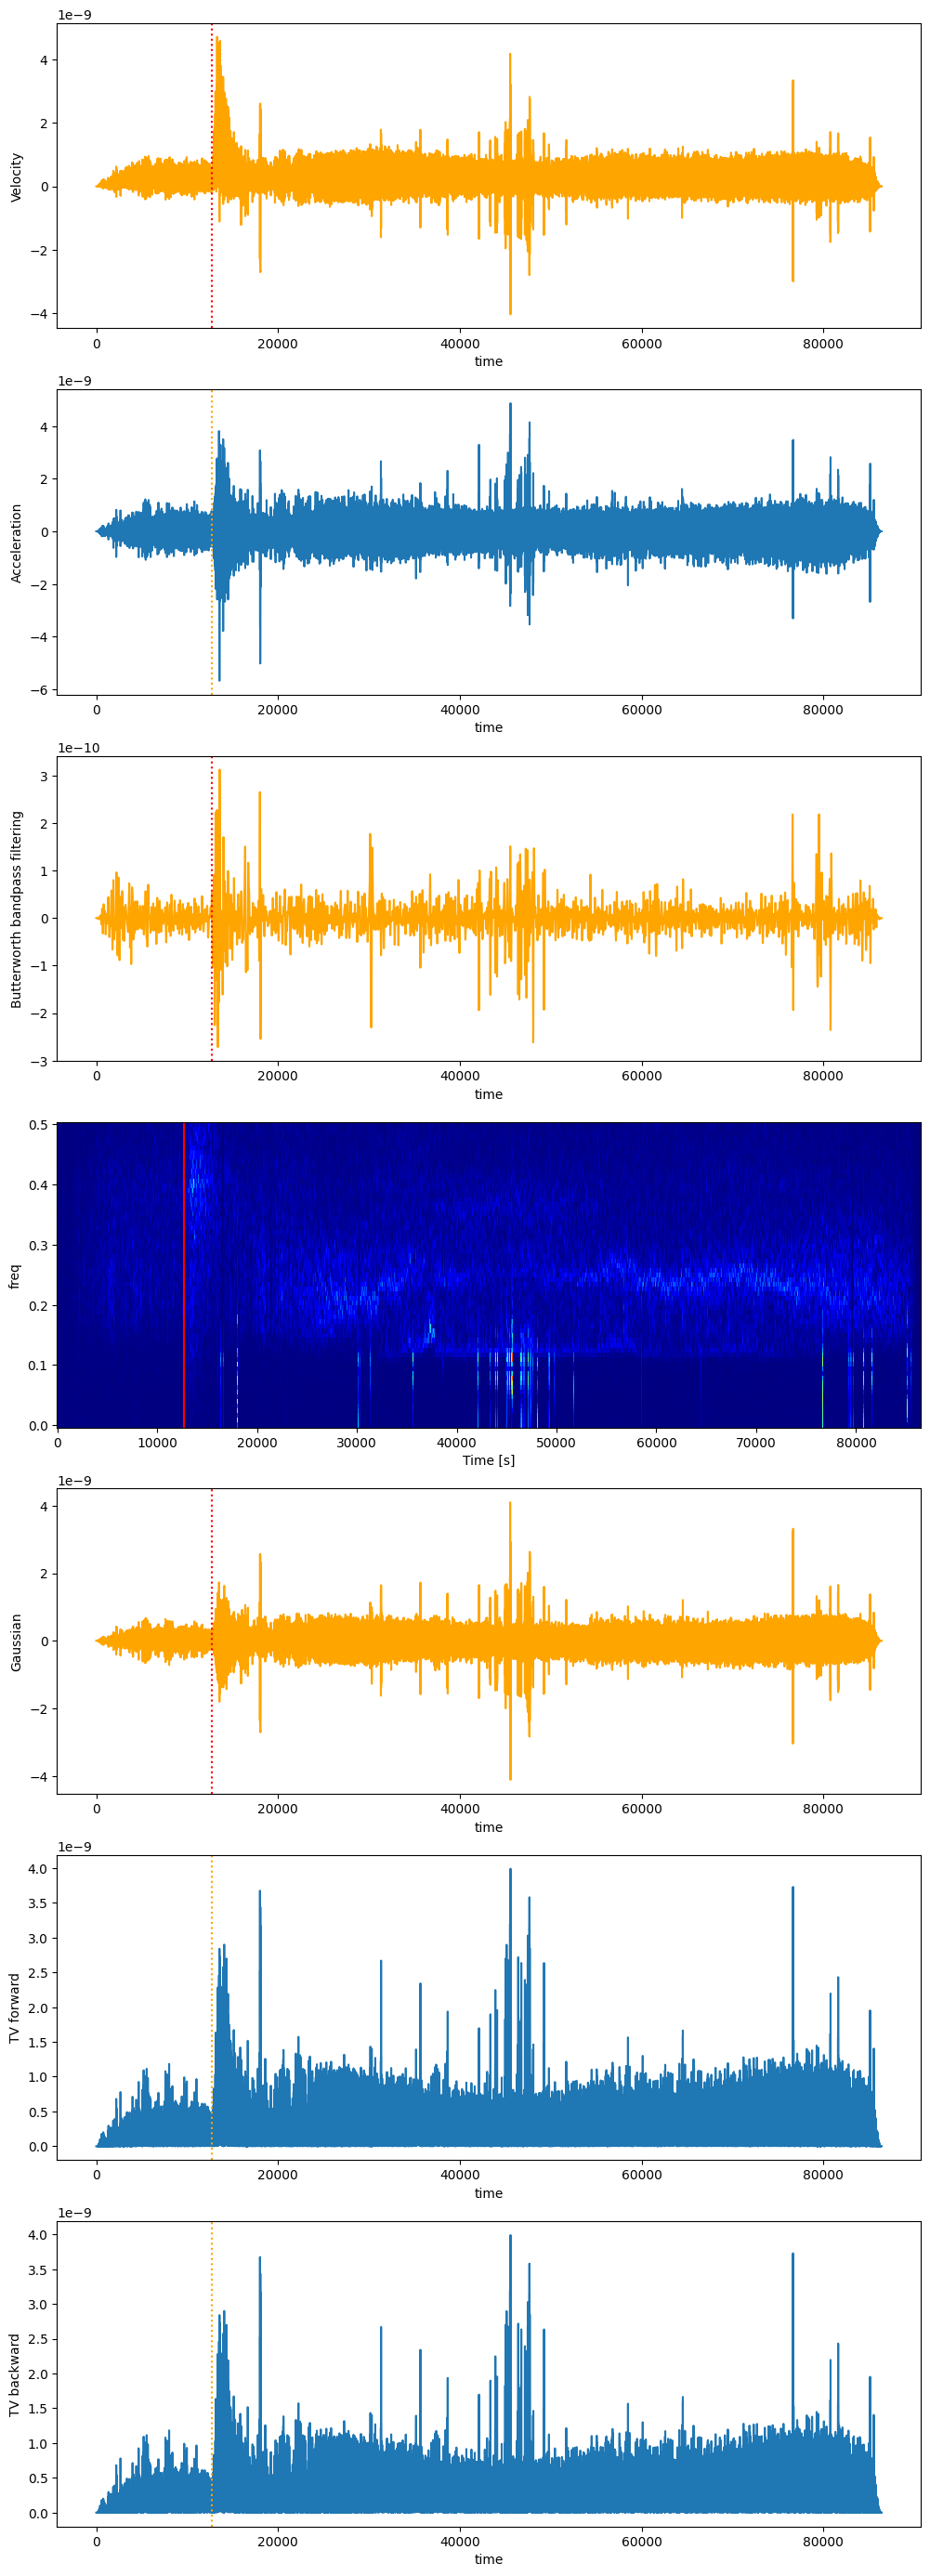

In [8]:
main('s', 1, nperseg = 128)

## Low Resolution analysis


#### 1 minute

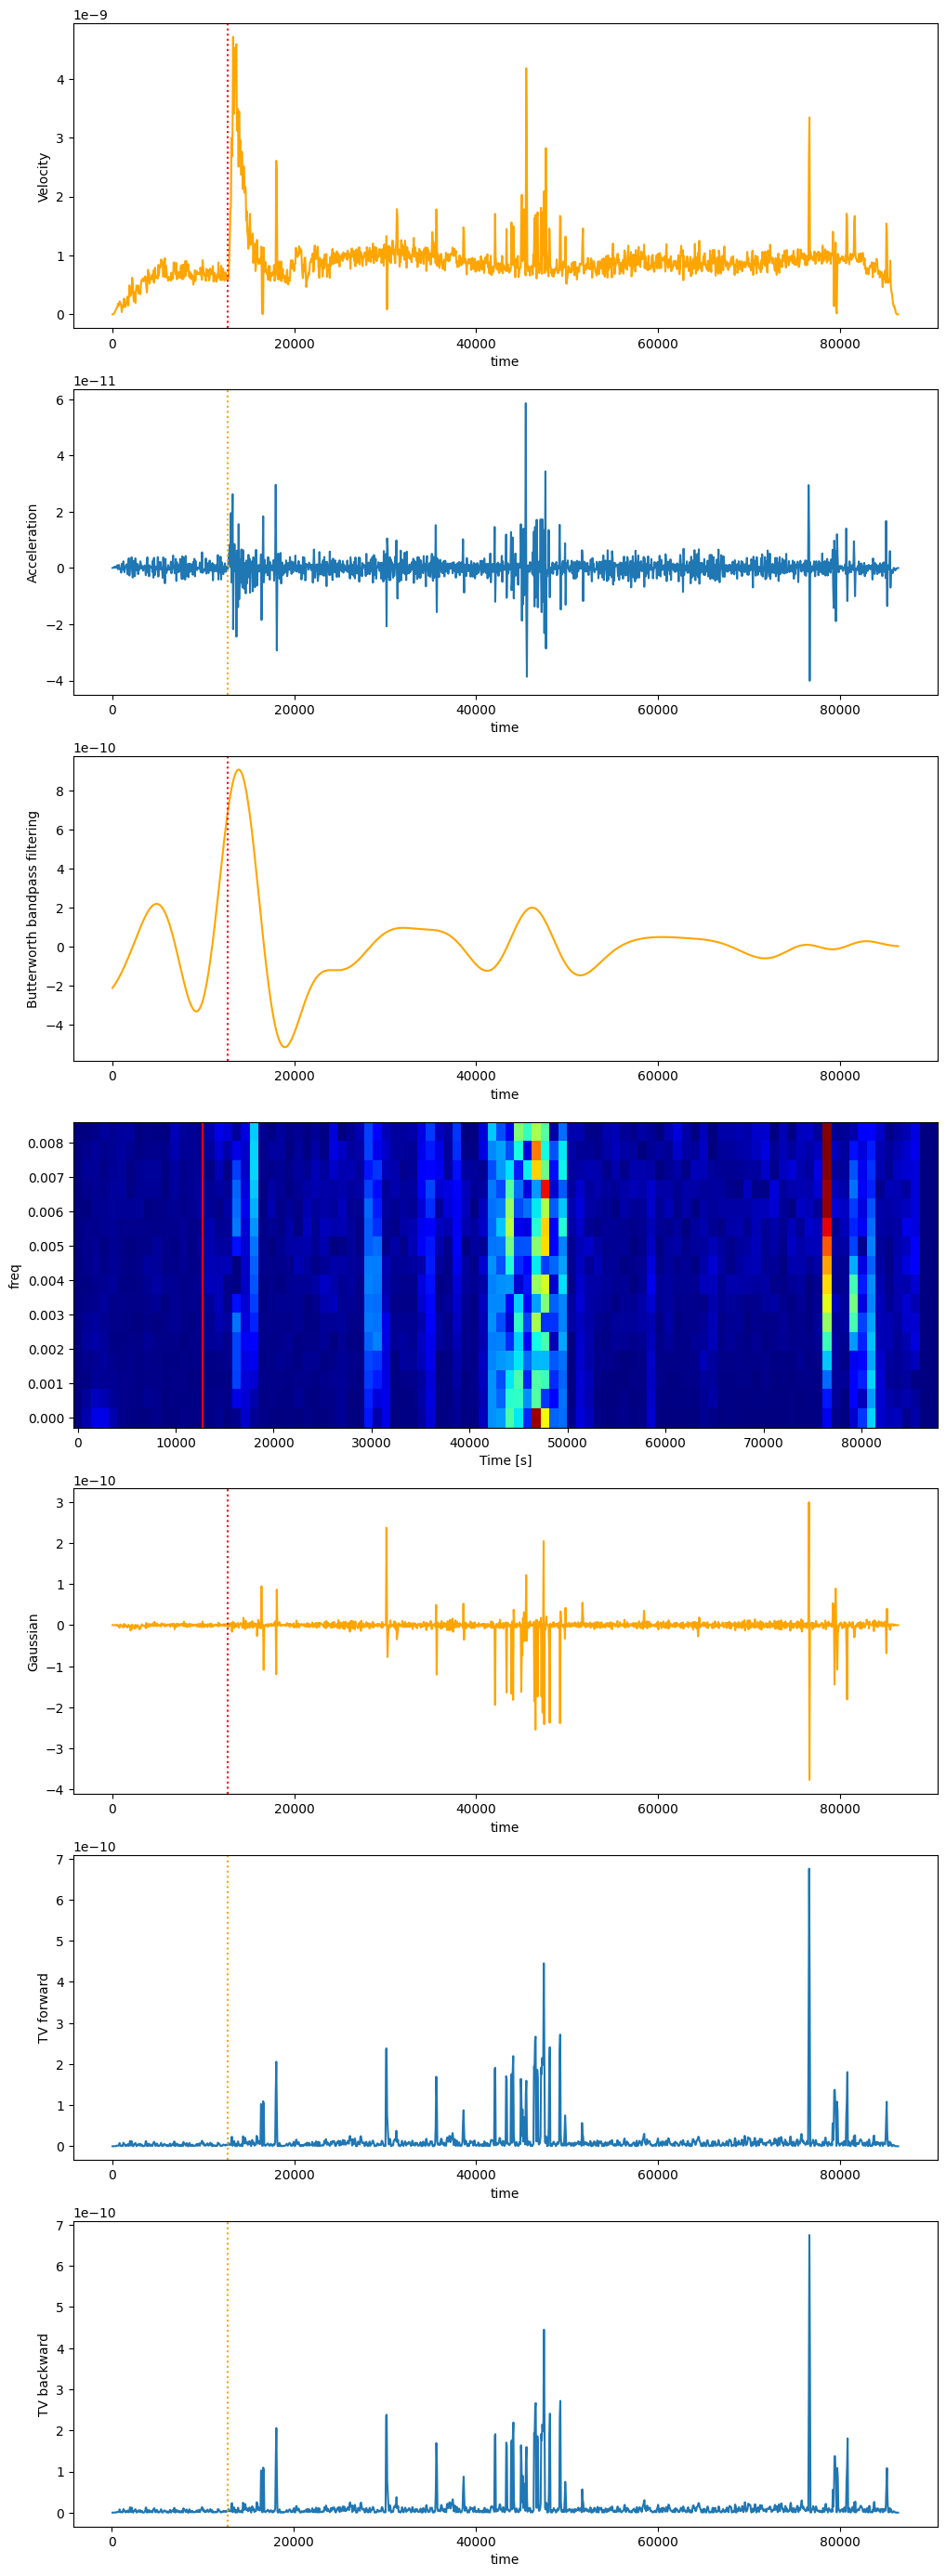

In [13]:
main('min', 60, nperseg = 30)

#### 5 minutes

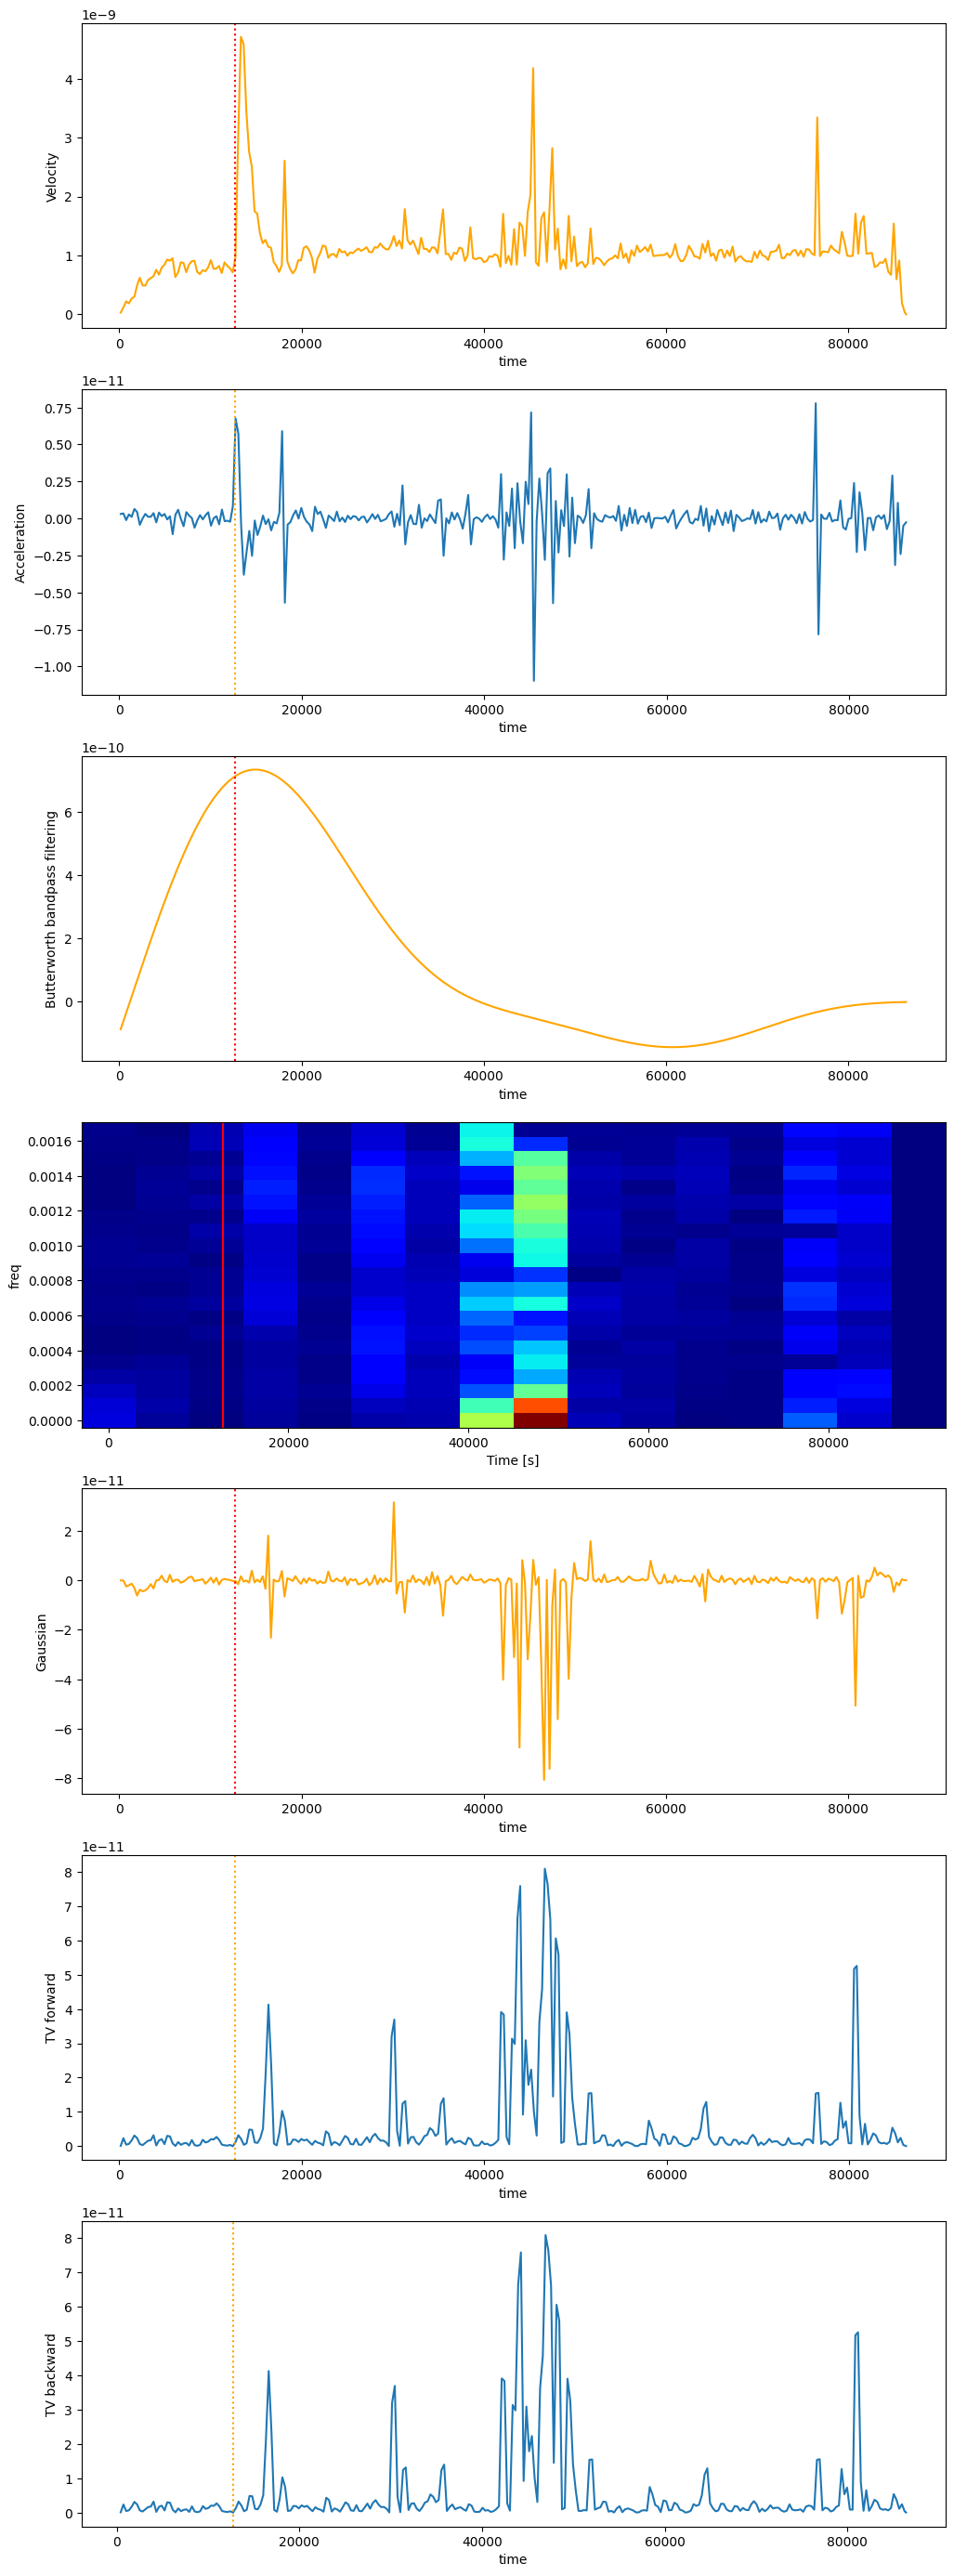

In [10]:
main('5min', 5 * 60, nperseg = 40)

#### 10 minutes

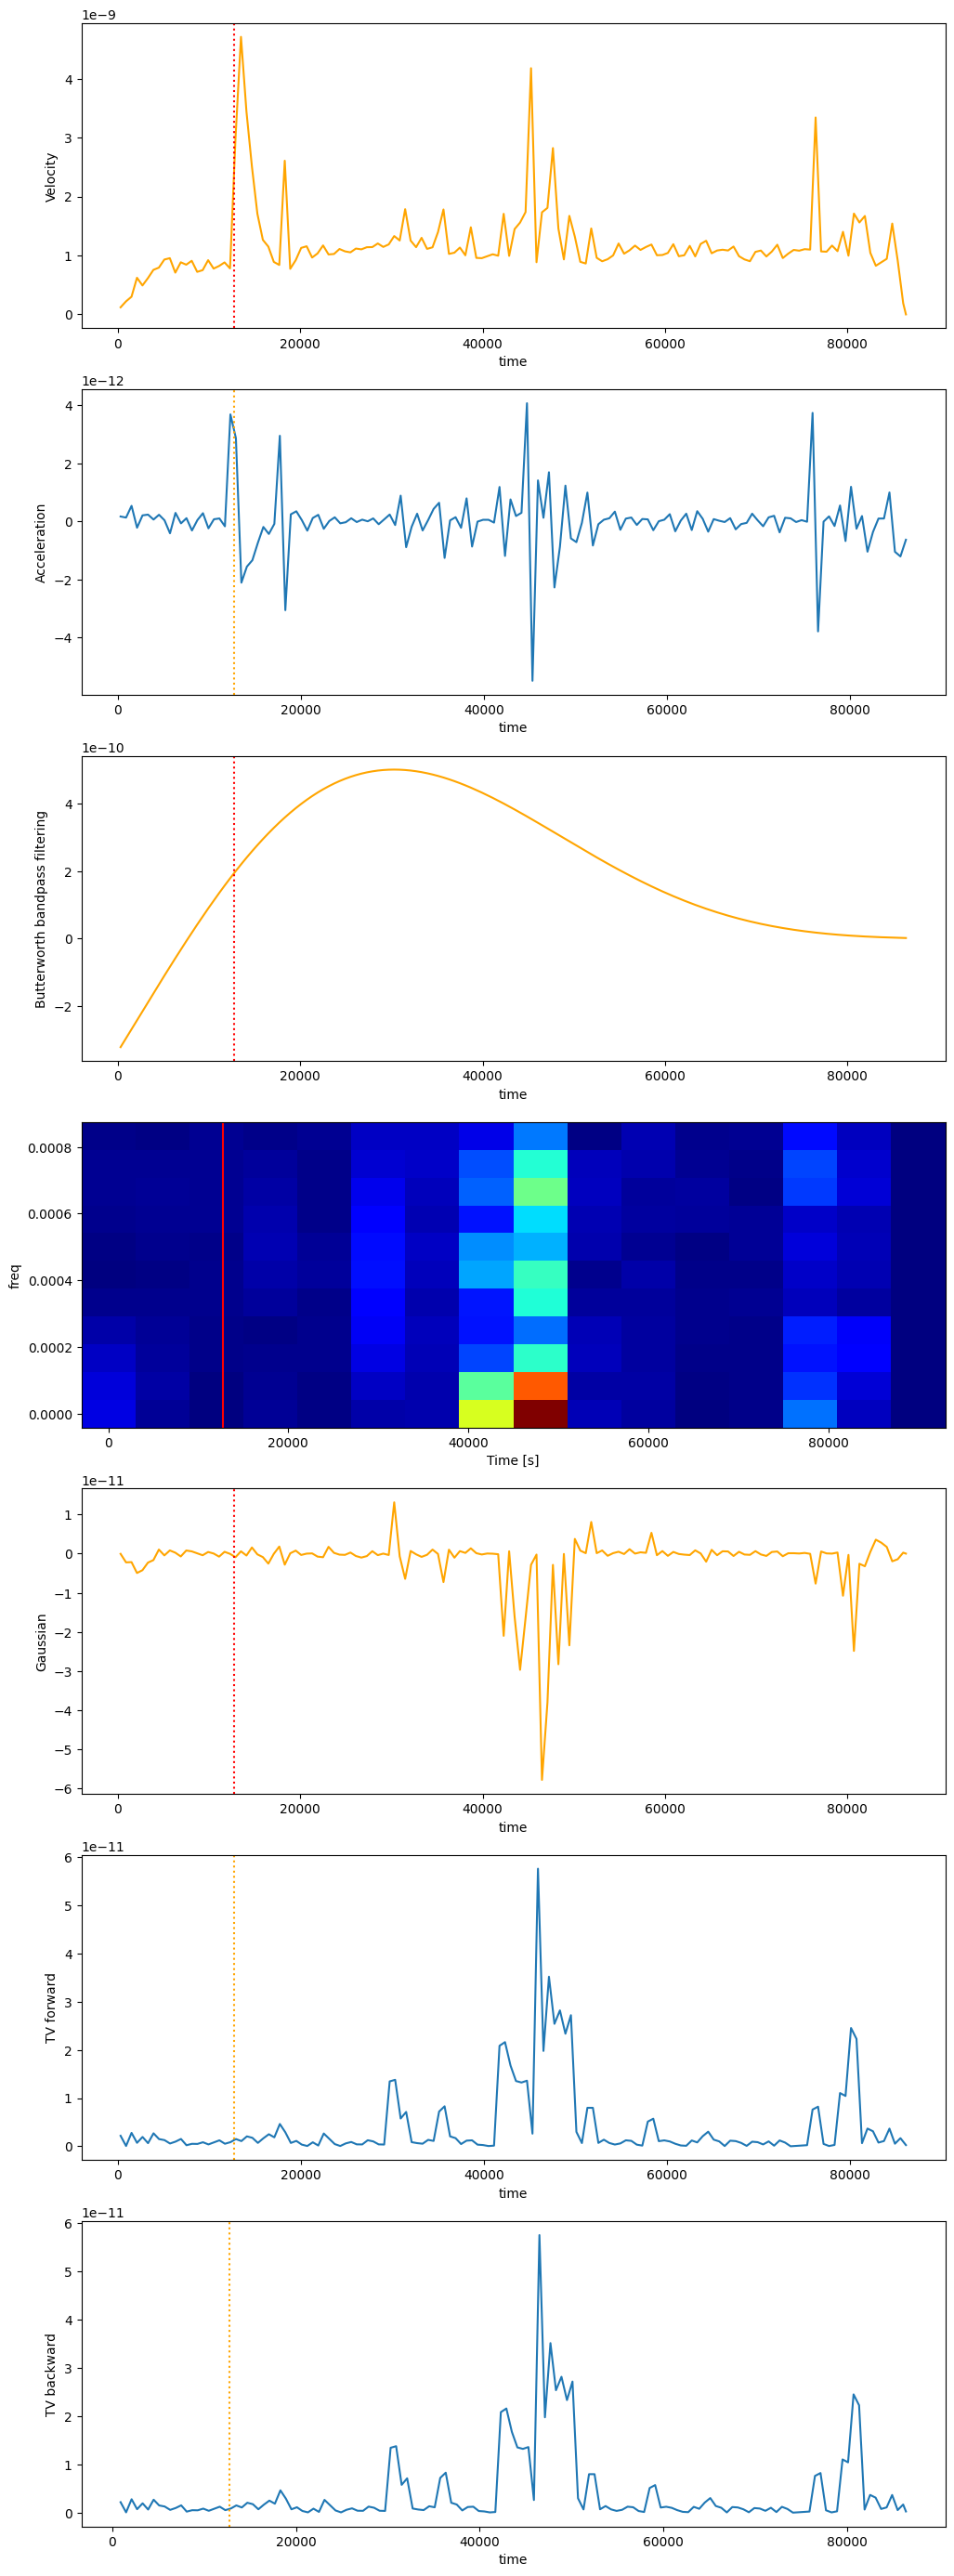

In [11]:
main('10min', 10 * 60, nperseg = 20)

### Conclusions
Up to this point, it is clear that lowering the data resolution gives us much more insights into the characteristics of these events for the bandpass filtering, that's why it will be our main approach towards feature engineering for the machine learning models.